Cleared output. Now showing results for iteration 9990
rewards_last_100 sum for episodes 9960 to 9990: 137.60000000000005


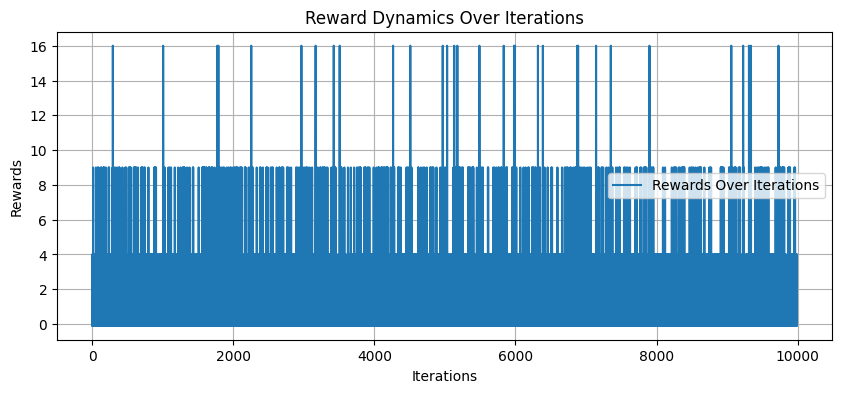

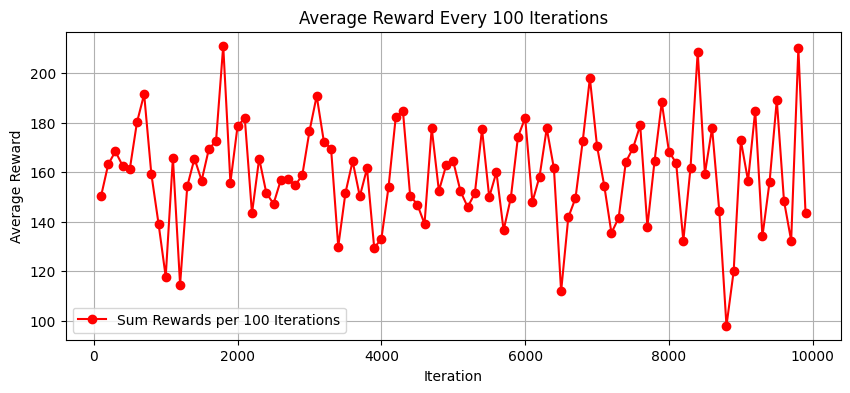

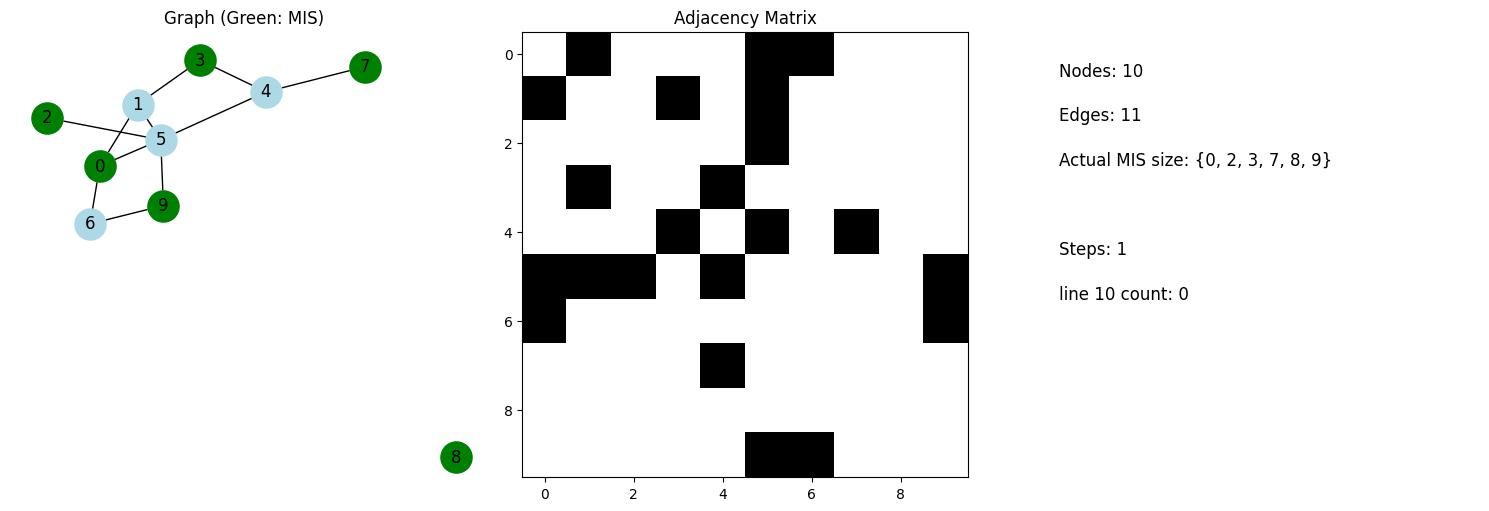

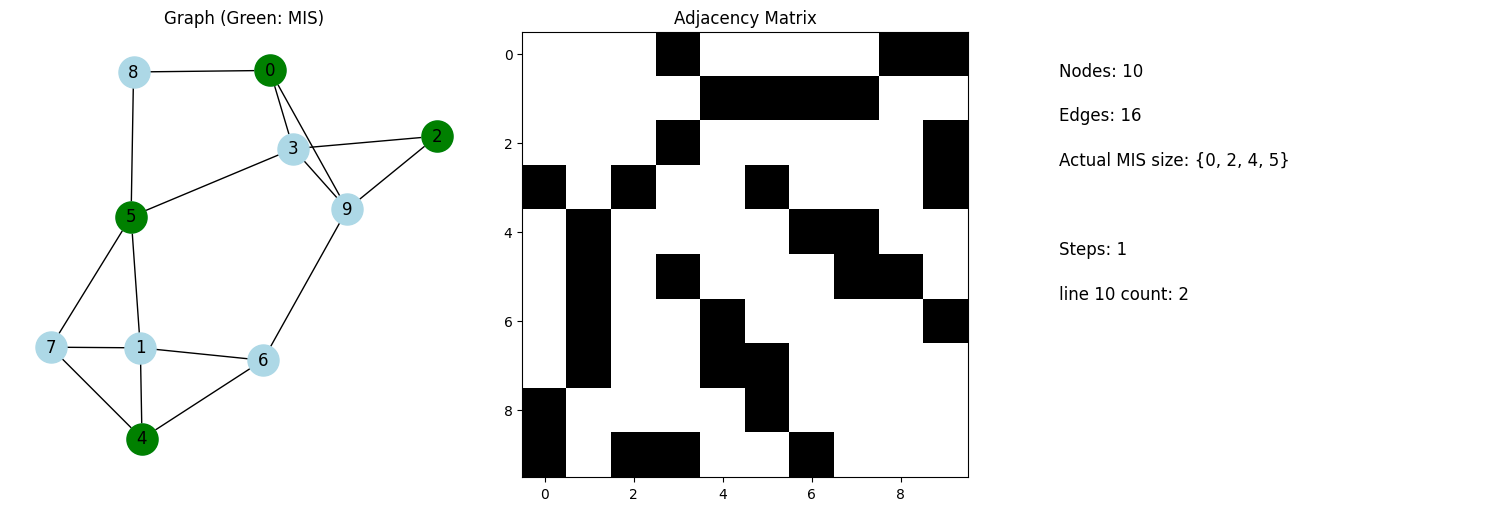

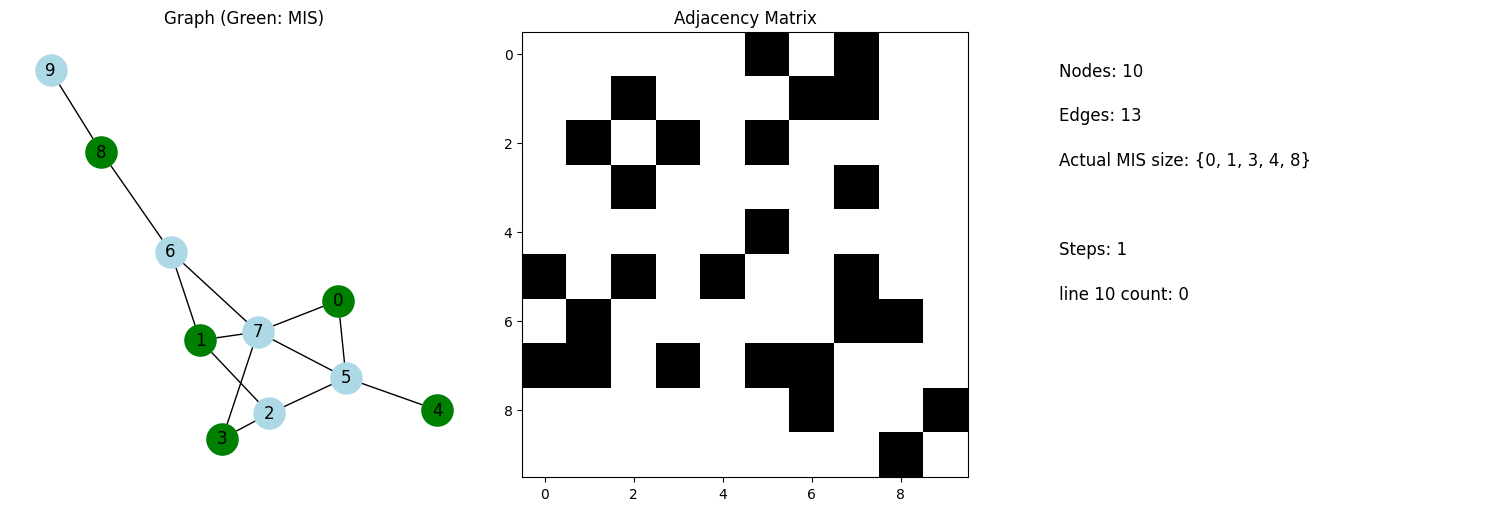

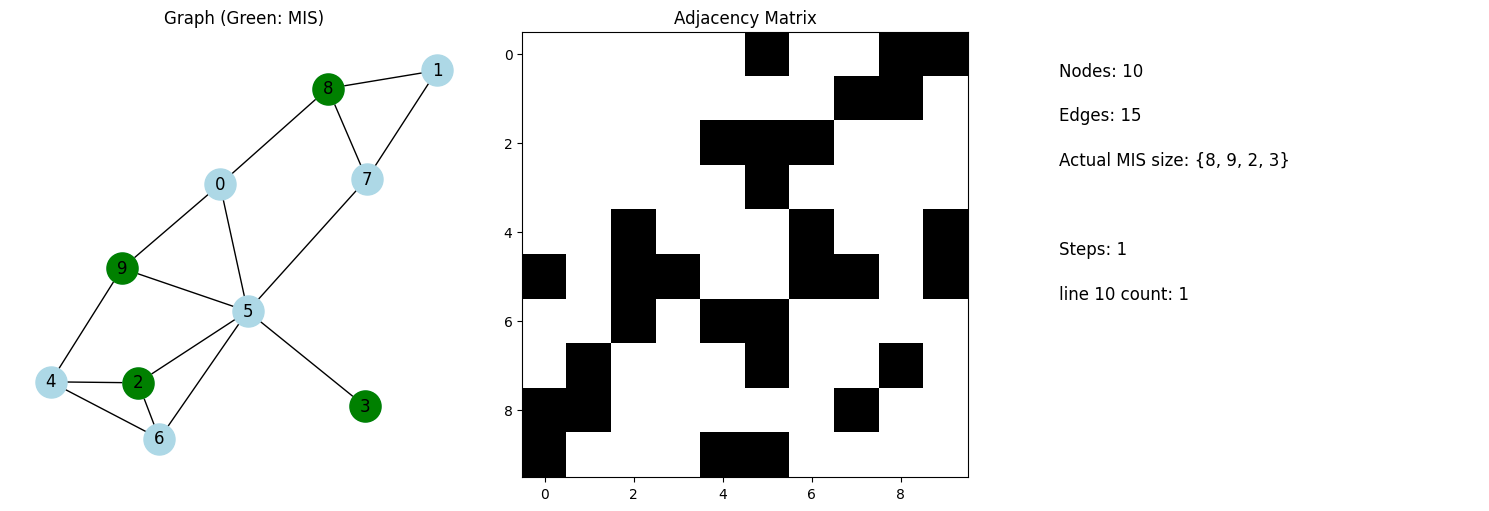

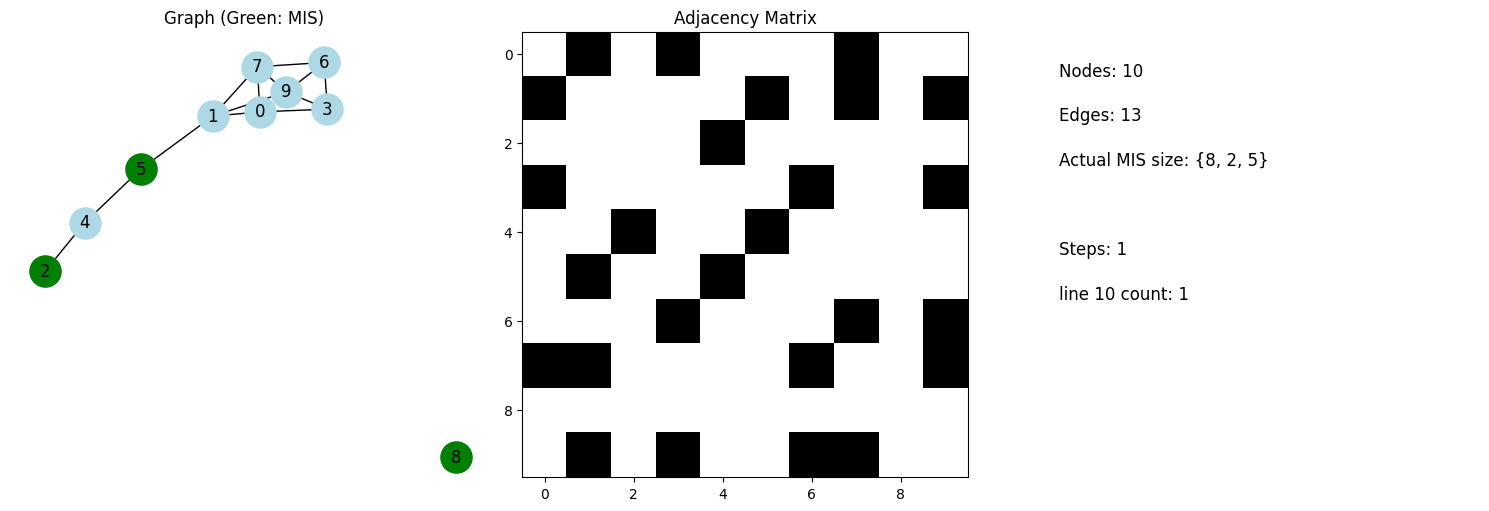

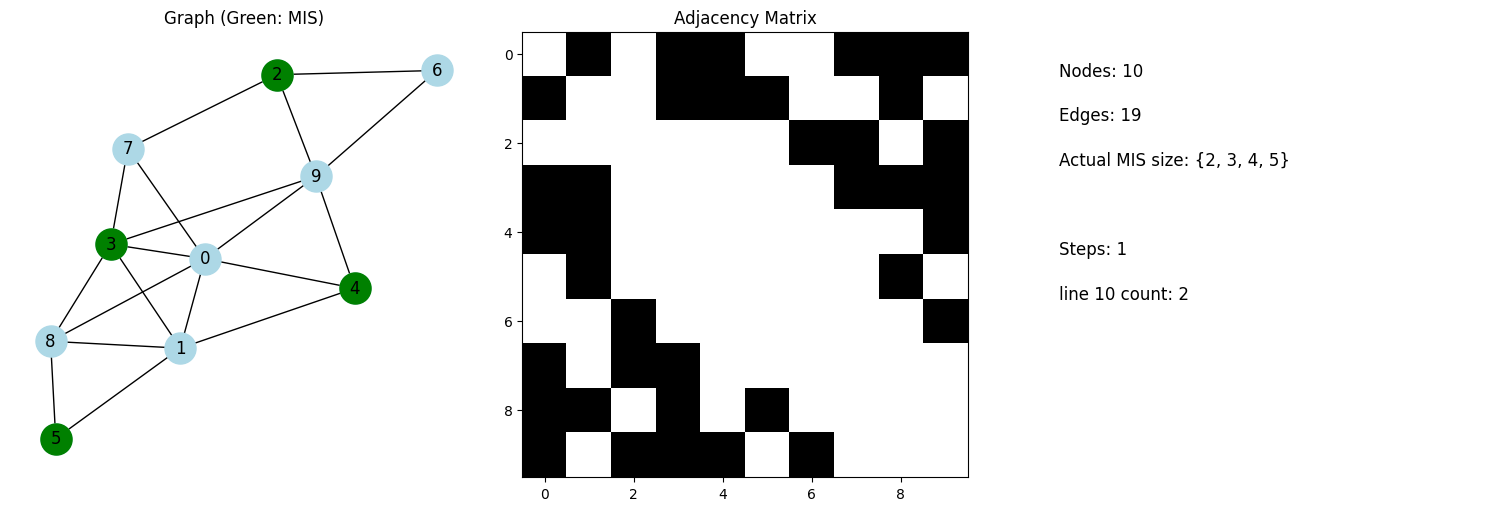

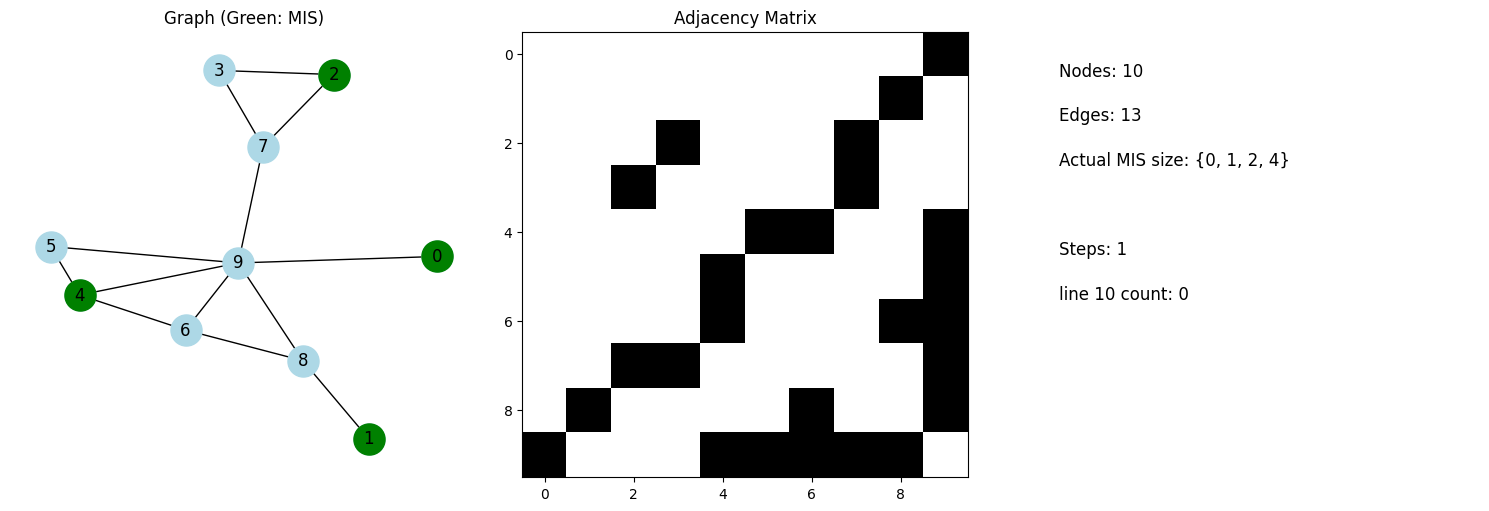

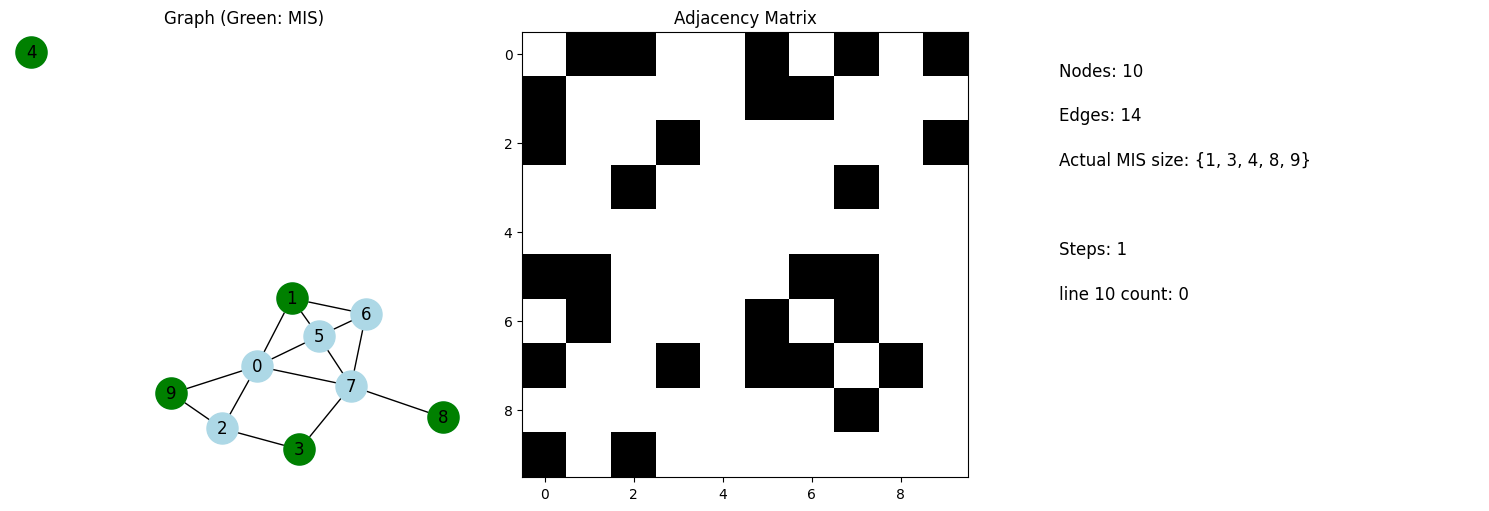

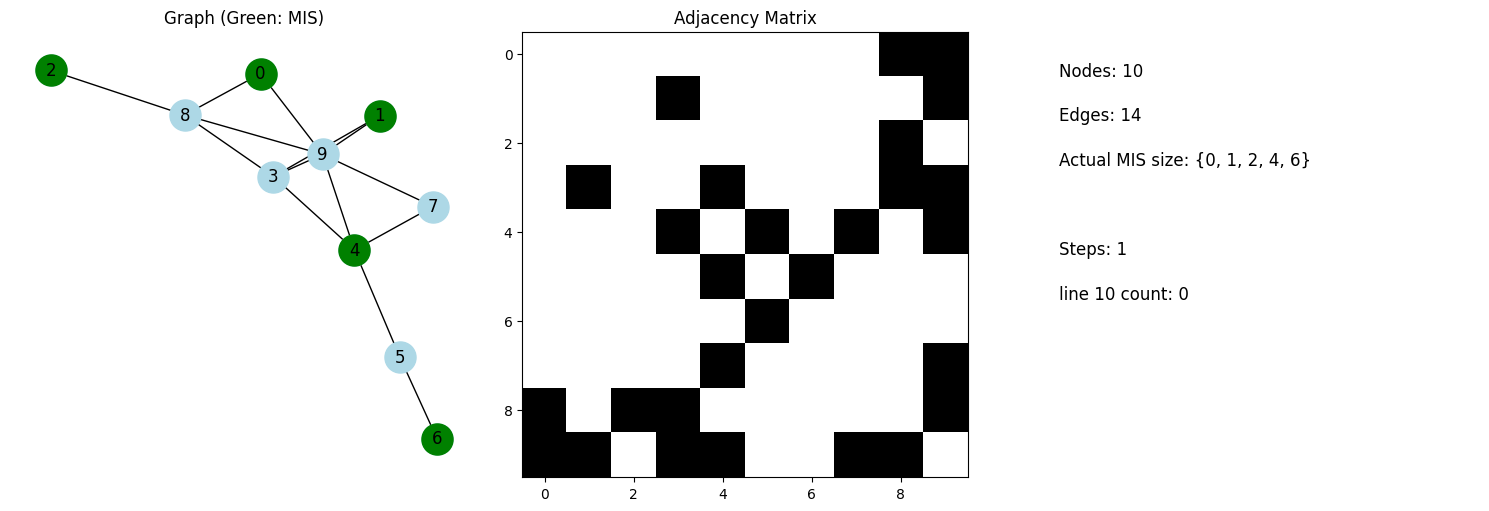

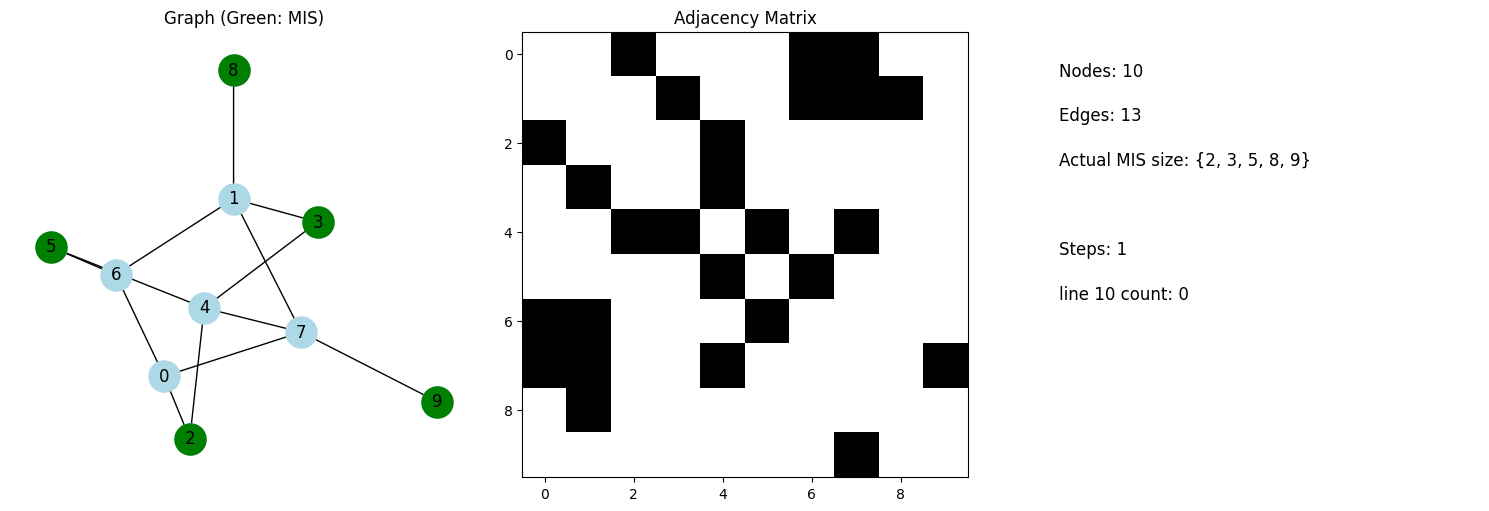

Average Reward for last 100 iterations: 148.10000000000008


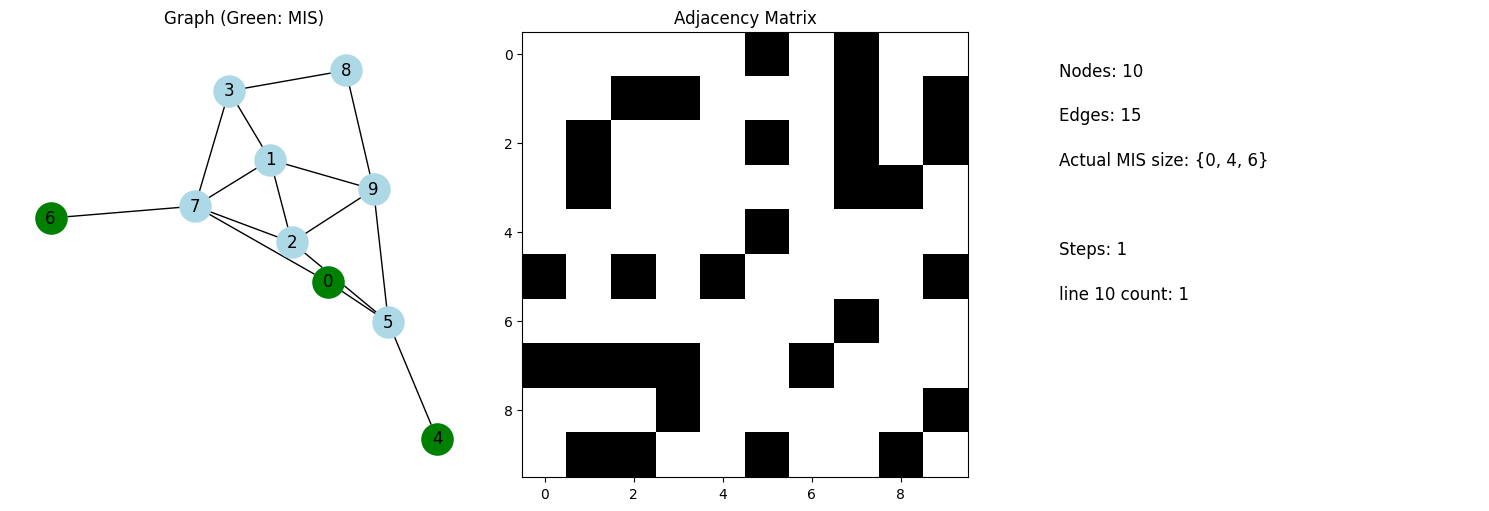


Final Evaluation:
Final Evaluation - Total Reward: -0.1


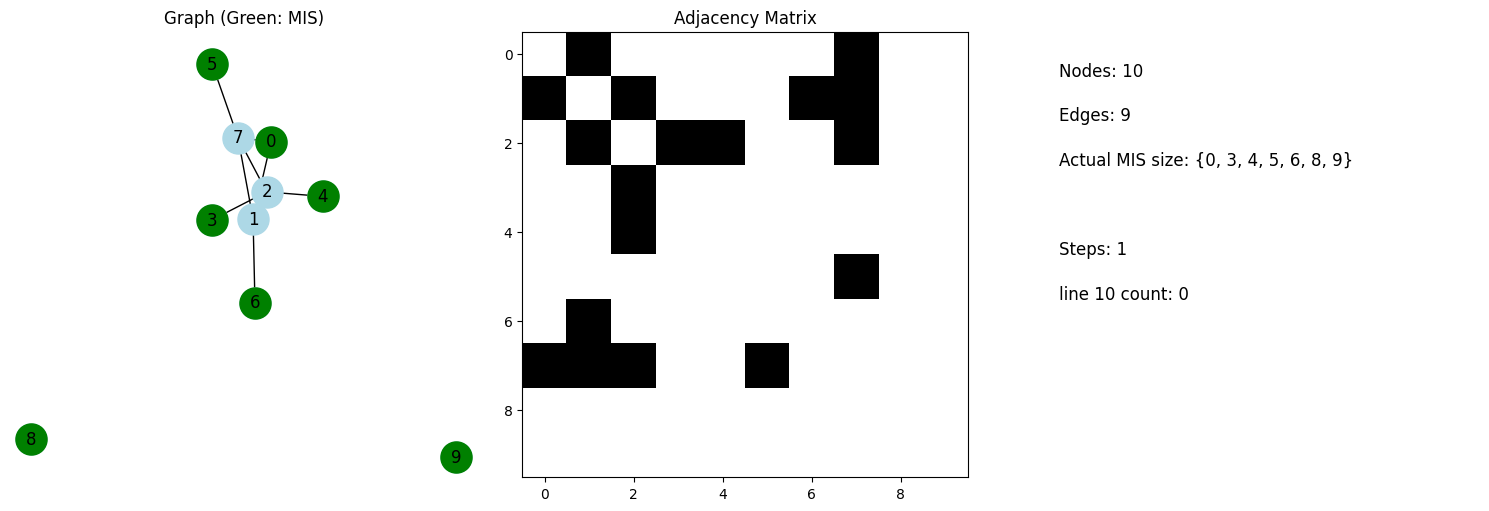

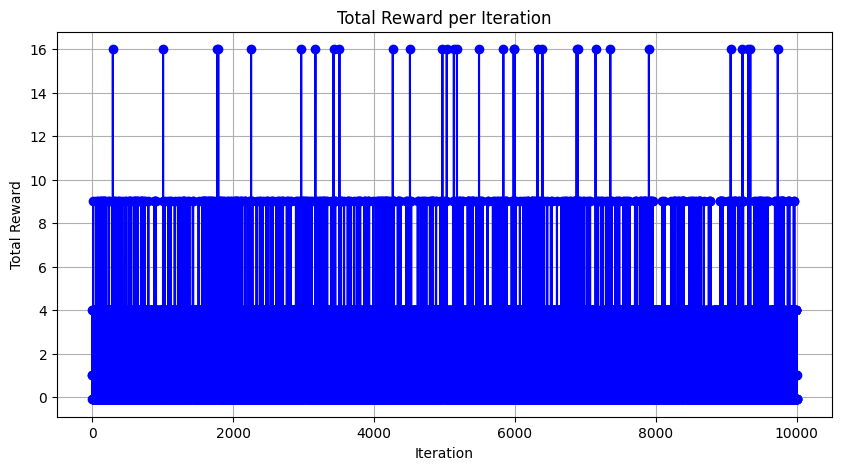

Detailed results have been recorded in 'detailed_results.csv'


In [1]:
# %%
import csv
import gymnasium as gym
from gymnasium import spaces
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from IPython.display import clear_output, display
import util

class MaxIndependentSetEnv(gym.Env):
    def __init__(self, n_nodes=10, max_steps=10000):
        super(MaxIndependentSetEnv, self).__init__()
        self.n_nodes = n_nodes
        self.max_steps = max_steps
        # Action space represents upper half triangle of the adjacency matrix (excluding the diagonal)
        num_actions = (n_nodes * (n_nodes - 1)) // 2
        #self.action_space = spaces.Box(low=0, high=1, shape=(num_actions,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(num_actions,), dtype=np.float32)
        # Full adjacency matrix remains as observation space
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.int8)
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.graph = None
        self.actual_mis = set()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps = 0
        self.graph = nx.empty_graph(self.n_nodes)
        self.adj_matrix = nx.adjacency_matrix(self.graph).todense().astype(np.int8)
        self.actual_mis, _ = util.mis(self.graph)
        #return self.adj_matrix, {}
        observation = self.adj_matrix
        info = {}
        return observation, info
    
    def action_to_adjacency(self, action):
        """ Convert the action into a full adjacency matrix. """
        adj_matrix = np.zeros((self.n_nodes, self.n_nodes), dtype=int)
        upper_indices = np.triu_indices(self.n_nodes, k=1)
        adj_matrix[upper_indices] = action
        # Make symmetric since it's an undirected graph
        adj_matrix += adj_matrix.T
        return adj_matrix
    
    def step(self, action):
        self.steps += 1
        action = np.round(action).astype(np.int8)
        self.adj_matrix = self.action_to_adjacency(action)  # Convert action to diagonal matrix
        self.graph = nx.from_numpy_array(self.adj_matrix)

        # Use diagonal matrix to determine nodes in independent set
        #independent_set = {i for i, v in enumerate(action) if v == 1}
        independent_set, step_count = util.mis(self.graph)
        self.independent_set = independent_set
        self.step_count = step_count
        #print(self.step_count)
        # Calculate reward
        if self.step_count[10] == 0:
            reward = -0.1
        else:
            reward = self.step_count[10]**2

        done = True
        #return self.adj_matrix, reward, done, {}
        observation = self.adj_matrix
        terminated = done
        truncated = False
        info = {}
        return observation, reward, terminated, truncated, info


    def render(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True, node_color='lightblue', node_size=500)
        nx.draw_networkx_nodes(self.graph, pos, nodelist=list(self.independent_set), node_color='green', node_size=500)
        #nx.draw_networkx_nodes(self.graph, pos, nodelist=list(self.actual_mis), node_color='green', node_size=500, alpha=0.5)
        plt.title("Graph (Green: MIS)")

        plt.subplot(132)
        plt.imshow(self.adj_matrix, cmap='binary')
        plt.title("Adjacency Matrix")

        plt.subplot(133)
        plt.axis('off')
        plt.text(0.1, 0.9, f"Nodes: {self.n_nodes}", fontsize=12)
        plt.text(0.1, 0.8, f"Edges: {self.graph.number_of_edges()}", fontsize=12)

        plt.text(0.1, 0.7, f"Actual MIS size: {self.independent_set}", fontsize=12)
        plt.text(0.1, 0.5, f"Steps: {self.steps}", fontsize=12)
        plt.text(0.1, 0.4, f"line 10 count: {self.step_count[10]}", fontsize=12)

        plt.tight_layout()
        plt.show()

# List to store rewards
rewards_per_iteration = []

# Create and train the model
env = MaxIndependentSetEnv(n_nodes=10, max_steps=10000)
policy_kwargs = dict(net_arch=[512, 512, 512])
model = PPO("MlpPolicy", env, verbose=1, 
            policy_kwargs=policy_kwargs, learning_rate=1e-3, 
            batch_size=32)

total_timesteps = 500000
num_iterations = 10000

# List to collect rewards every 100 episodes
rewards_last_100 = []
model.learn(total_timesteps = 10)

# Open a CSV file to write all details

# List to store rewards
rewards_per_iteration = []
rewards_last_100 = []
average_rewards_100 = []

# Open a CSV file to write all details
with open('detailed_results.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    
    # Write header
    header = ['Iteration', 'Total Reward', 'Actual MIS Size', 'Generated MIS Size']
    header += [f'Line {i} Count' for i in range(1, 11)]
    header += ['Adjacency Matrix']
    csvwriter.writerow(header)

    for i in range(num_iterations):    
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _, _ = env.step(action)
            total_reward += reward
        
        rewards_per_iteration.append(total_reward)
        rewards_last_100.append(total_reward)
        
        # Prepare data for CSV
        row_data = [i+1, total_reward, len(env.actual_mis), len(env.independent_set)]
        row_data += [env.step_count.get(i, 0) for i in range(1, 11)]
        adj_matrix_str = ';'.join(','.join(str(cell) for cell in row) for row in env.adj_matrix)
        row_data.append(adj_matrix_str)
        csvwriter.writerow(row_data)
        
        # Check if we've completed 100 iterations
        if (i + 1) % 100 == 0:
            #average_reward = sum(rewards_last_100) / 100
            average_reward = sum(rewards_last_100)
            average_rewards_100.append(average_reward)
            print(f"Sum Reward for last 100 iterations: {average_reward}")
            rewards_last_100 = []

        remainder = 30
        if (i + 1) % remainder == 0:
            clear_output(wait=True)
            print(f"Cleared output. Now showing results for iteration {i+1}")
            print(f"rewards_last_100 sum for episodes {i-remainder+1} to {i+1}: {sum(rewards_last_100)}")
            
            # Plotting the rewards every 30 iterations
            plt.figure(figsize=(10, 4))
            plt.plot(rewards_per_iteration, label='Rewards Over Iterations')
            plt.xlabel('Iterations')
            plt.ylabel('Rewards')
            plt.title('Reward Dynamics Over Iterations')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # Plot the average rewards every 100 iterations
            if average_rewards_100:
                plt.figure(figsize=(10, 4))
                plt.plot(range(100, 100 * len(average_rewards_100) + 1, 100), average_rewards_100, marker='o', linestyle='-', color='r', label='Sum Rewards per 100 Iterations')
                plt.xlabel('Iteration')
                plt.ylabel('Average Reward')
                plt.title('Average Reward Every 100 Iterations')
                plt.legend()
                plt.grid(True)
                plt.show()

        
        #print(f"Episode {i+1} - Total Sum Reward: {sum(rewards_last_100)}")
        env.render()

# Final evaluation
print("\nFinal Evaluation:")
obs, _ = env.reset()
done = False
total_reward = 0
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

print(f"Final Evaluation - Total Reward: {total_reward}")
env.render()

# Plot the rewards
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_iterations + 1), rewards_per_iteration, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Total Reward')
plt.title('Total Reward per Iteration')
plt.grid(True)
plt.show()

print("Detailed results have been recorded in 'detailed_results.csv'")